# Logistic Regression: A Complete Guide to Classification

## Table of Contents
1. [Introduction to Classification](#intro)
2. [From Linear to Logistic Regression](#linear-to-logistic)
3. [The Logistic Function (Sigmoid)](#sigmoid)
4. [Maximum Likelihood Estimation](#mle)
5. [Cost Function and Optimization](#cost-function)
6. [Decision Boundaries](#decision-boundaries)
7. [Multiclass Classification](#multiclass)
8. [Model Evaluation Metrics](#evaluation)
9. [Regularization in Logistic Regression](#regularization)
10. [Practical Applications](#applications)

---

## 1. Introduction to Classification <a id='intro'></a>

**Classification** is a supervised learning task where the goal is to predict categorical labels.

### Types of Classification Problems

**Binary Classification**: Two possible classes
- Spam vs Not Spam
- Disease vs Healthy
- Fraud vs Legitimate
- Positive vs Negative sentiment

**Multiclass Classification**: More than two classes
- Handwritten digit recognition (0-9)
- Species classification
- Image classification (cat, dog, bird, etc.)

**Multilabel Classification**: Multiple labels per instance
- Movie genres (action, comedy, drama)
- Document tagging

### Why Not Linear Regression?

For classification, linear regression has several problems:

1. **Output is not bounded**: Can predict values outside [0,1]
2. **Not probabilistic**: Doesn't give class probabilities
3. **Sensitive to outliers**: Extreme values distort decision boundary
4. **Assumes linear relationship**: Not appropriate for categorical outcomes

### Enter Logistic Regression

Logistic Regression solves these issues by:
- Transforming linear combination through sigmoid function
- Outputting probabilities in range [0, 1]
- Using appropriate loss function (log loss)
- Providing probabilistic interpretation

Despite its name, **logistic regression is a classification algorithm**, not a regression algorithm.

### Mathematical Setup

Given:
- Training data: $(\mathbf{x}_i, y_i)$ where $i = 1, \ldots, n$
- Features: $\mathbf{x}_i \in \mathbb{R}^p$
- Binary labels: $y_i \in \{0, 1\}$

Goal: Learn function $h(\mathbf{x})$ that predicts probability:
$$P(y = 1 | \mathbf{x})$$

In [1]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, confusion_matrix, classification_report,
                             roc_curve, auc, precision_recall_curve, log_loss)
from sklearn.datasets import make_classification, make_blobs, load_breast_cancer
from scipy.special import expit
from scipy.optimize import minimize
import pandas as pd
import warnings

# Set styles
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

print("Libraries imported successfully")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")

Libraries imported successfully
NumPy version: 2.0.2
Pandas version: 2.2.2


## 2. From Linear to Logistic Regression <a id='linear-to-logistic'></a>

### Linear Regression Approach (Problematic)

Linear regression models:
$$h(\mathbf{x}) = \mathbf{w}^T\mathbf{x} + b$$

Problems for classification:
- Output can be any real number: $h(\mathbf{x}) \in (-\infty, \infty)$
- We need probabilities: $P(y=1|\mathbf{x}) \in [0, 1]$

### Logistic Regression Approach

Apply sigmoid function to linear combination:
$$h(\mathbf{x}) = \sigma(\mathbf{w}^T\mathbf{x} + b)$$

where $\sigma(z) = \frac{1}{1 + e^{-z}}$ is the sigmoid (logistic) function.

Now: $h(\mathbf{x}) \in [0, 1]$ and can be interpreted as a probability.

### Interpretation

**Model Output**:
$$P(y = 1 | \mathbf{x}) = \sigma(\mathbf{w}^T\mathbf{x} + b)$$
$$P(y = 0 | \mathbf{x}) = 1 - \sigma(\mathbf{w}^T\mathbf{x} + b)$$

**Decision Rule**:
$$\hat{y} = \begin{cases} 
1 & \text{if } h(\mathbf{x}) \geq 0.5 \\
0 & \text{if } h(\mathbf{x}) < 0.5
\end{cases}$$

This threshold of 0.5 can be adjusted based on application needs.

### Key Differences

| Aspect | Linear Regression | Logistic Regression |
|--------|------------------|---------------------|
| Task | Regression | Classification |
| Output | Continuous | Probability [0,1] |
| Output Function | Identity | Sigmoid |
| Loss Function | MSE | Log Loss |
| Interpretation | Direct prediction | Probability |
| Decision Boundary | N/A | Hyperplane |

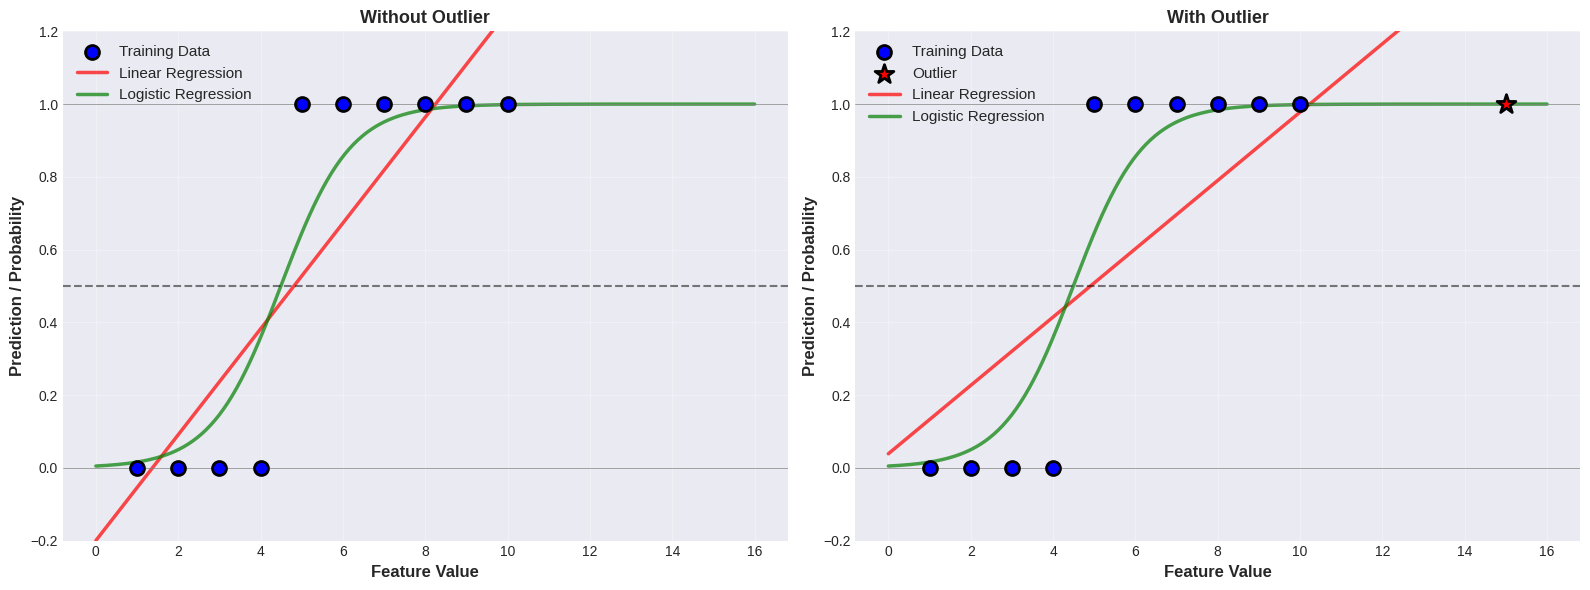

Key Observations:

Linear Regression Problems:
  1. Predictions can be < 0 or > 1 (not valid probabilities)
  2. Very sensitive to outliers (right plot)
  3. Decision boundary shifts dramatically with outlier

Logistic Regression Advantages:
  1. Always outputs values in [0, 1]
  2. S-shaped curve fits classification better
  3. More robust to outliers
  4. Outputs can be interpreted as probabilities


In [2]:
# Demonstrate why linear regression fails for classification

# Generate simple binary classification data
np.random.seed(42)
X_simple = np.array([[1], [2], [3], [4], [5], [6], [7], [8], [9], [10]])
y_simple = np.array([0, 0, 0, 0, 1, 1, 1, 1, 1, 1])

# Add an outlier
X_outlier = np.vstack([X_simple, [[15]]])
y_outlier = np.hstack([y_simple, [1]])

# Fit both models
linear_model = LinearRegression()
linear_model.fit(X_simple, y_simple)

linear_model_outlier = LinearRegression()
linear_model_outlier.fit(X_outlier, y_outlier)

logistic_model = LogisticRegression()
logistic_model.fit(X_simple, y_simple)

logistic_model_outlier = LogisticRegression()
logistic_model_outlier.fit(X_outlier, y_outlier)

# Create prediction range
X_range = np.linspace(0, 16, 300).reshape(-1, 1)

# Predictions
y_linear = linear_model.predict(X_range)
y_linear_outlier = linear_model_outlier.predict(X_range)
y_logistic = logistic_model.predict_proba(X_range)[:, 1]
y_logistic_outlier = logistic_model_outlier.predict_proba(X_range)[:, 1]

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Without outlier
ax = axes[0]
ax.scatter(X_simple, y_simple, s=100, c='blue', edgecolors='black', 
          linewidths=2, label='Training Data', zorder=5)
ax.plot(X_range, y_linear, 'r-', linewidth=2.5, label='Linear Regression', alpha=0.7)
ax.plot(X_range, y_logistic, 'g-', linewidth=2.5, label='Logistic Regression', alpha=0.7)
ax.axhline(y=0.5, color='black', linestyle='--', linewidth=1.5, alpha=0.5)
ax.axhline(y=0, color='gray', linestyle='-', linewidth=0.5)
ax.axhline(y=1, color='gray', linestyle='-', linewidth=0.5)
ax.set_xlabel('Feature Value', fontsize=12, fontweight='bold')
ax.set_ylabel('Prediction / Probability', fontsize=12, fontweight='bold')
ax.set_title('Without Outlier', fontsize=13, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
ax.set_ylim([-0.2, 1.2])

# With outlier
ax = axes[1]
ax.scatter(X_simple, y_simple, s=100, c='blue', edgecolors='black',
          linewidths=2, label='Training Data', zorder=5)
ax.scatter([15], [1], s=200, c='red', marker='*', edgecolors='black',
          linewidths=2, label='Outlier', zorder=6)
ax.plot(X_range, y_linear_outlier, 'r-', linewidth=2.5, label='Linear Regression', alpha=0.7)
ax.plot(X_range, y_logistic_outlier, 'g-', linewidth=2.5, label='Logistic Regression', alpha=0.7)
ax.axhline(y=0.5, color='black', linestyle='--', linewidth=1.5, alpha=0.5)
ax.axhline(y=0, color='gray', linestyle='-', linewidth=0.5)
ax.axhline(y=1, color='gray', linestyle='-', linewidth=0.5)
ax.set_xlabel('Feature Value', fontsize=12, fontweight='bold')
ax.set_ylabel('Prediction / Probability', fontsize=12, fontweight='bold')
ax.set_title('With Outlier', fontsize=13, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
ax.set_ylim([-0.2, 1.2])

plt.tight_layout()
plt.show()

print("Key Observations:")
print("="*70)
print("\nLinear Regression Problems:")
print("  1. Predictions can be < 0 or > 1 (not valid probabilities)")
print("  2. Very sensitive to outliers (right plot)")
print("  3. Decision boundary shifts dramatically with outlier")
print("\nLogistic Regression Advantages:")
print("  1. Always outputs values in [0, 1]")
print("  2. S-shaped curve fits classification better")
print("  3. More robust to outliers")
print("  4. Outputs can be interpreted as probabilities")

## 3. The Logistic Function (Sigmoid) <a id='sigmoid'></a>

### Definition

The sigmoid (logistic) function is defined as:
$$\sigma(z) = \frac{1}{1 + e^{-z}} = \frac{e^z}{1 + e^z}$$

### Properties

**Range**: $\sigma(z) \in (0, 1)$ for all $z \in \mathbb{R}$

**Limits**:
- $\lim_{z \to -\infty} \sigma(z) = 0$
- $\lim_{z \to \infty} \sigma(z) = 1$
- $\sigma(0) = 0.5$

**Symmetry**: $\sigma(-z) = 1 - \sigma(z)$

**Derivative**: 
$$\frac{d\sigma(z)}{dz} = \sigma(z)(1 - \sigma(z))$$

This derivative form is particularly useful for optimization.

### Why Sigmoid?

1. **Maps to [0,1]**: Perfect for probabilities
2. **Smooth and differentiable**: Enables gradient-based optimization
3. **Interpretable**: $z = 0$ gives probability 0.5 (decision boundary)
4. **Biological inspiration**: Similar to neuron activation

### Odds and Log-Odds

The sigmoid function is intimately connected to odds:

**Odds**:
$$\text{odds} = \frac{P(y=1|\mathbf{x})}{P(y=0|\mathbf{x})} = \frac{\sigma(z)}{1-\sigma(z)} = e^z$$

**Log-Odds (Logit)**:
$$\log(\text{odds}) = \log\left(\frac{P(y=1|\mathbf{x})}{P(y=0|\mathbf{x})}\right) = z = \mathbf{w}^T\mathbf{x} + b$$

This shows logistic regression models the **log-odds as a linear function** of features.

### Alternative Activation Functions

While sigmoid is standard for binary classification, other functions exist:
- **Tanh**: $\tanh(z) = \frac{e^z - e^{-z}}{e^z + e^{-z}}$ (range [-1, 1])
- **Softmax**: Generalization for multiclass (discussed later)
- **ReLU**: $\max(0, z)$ (used in neural networks)

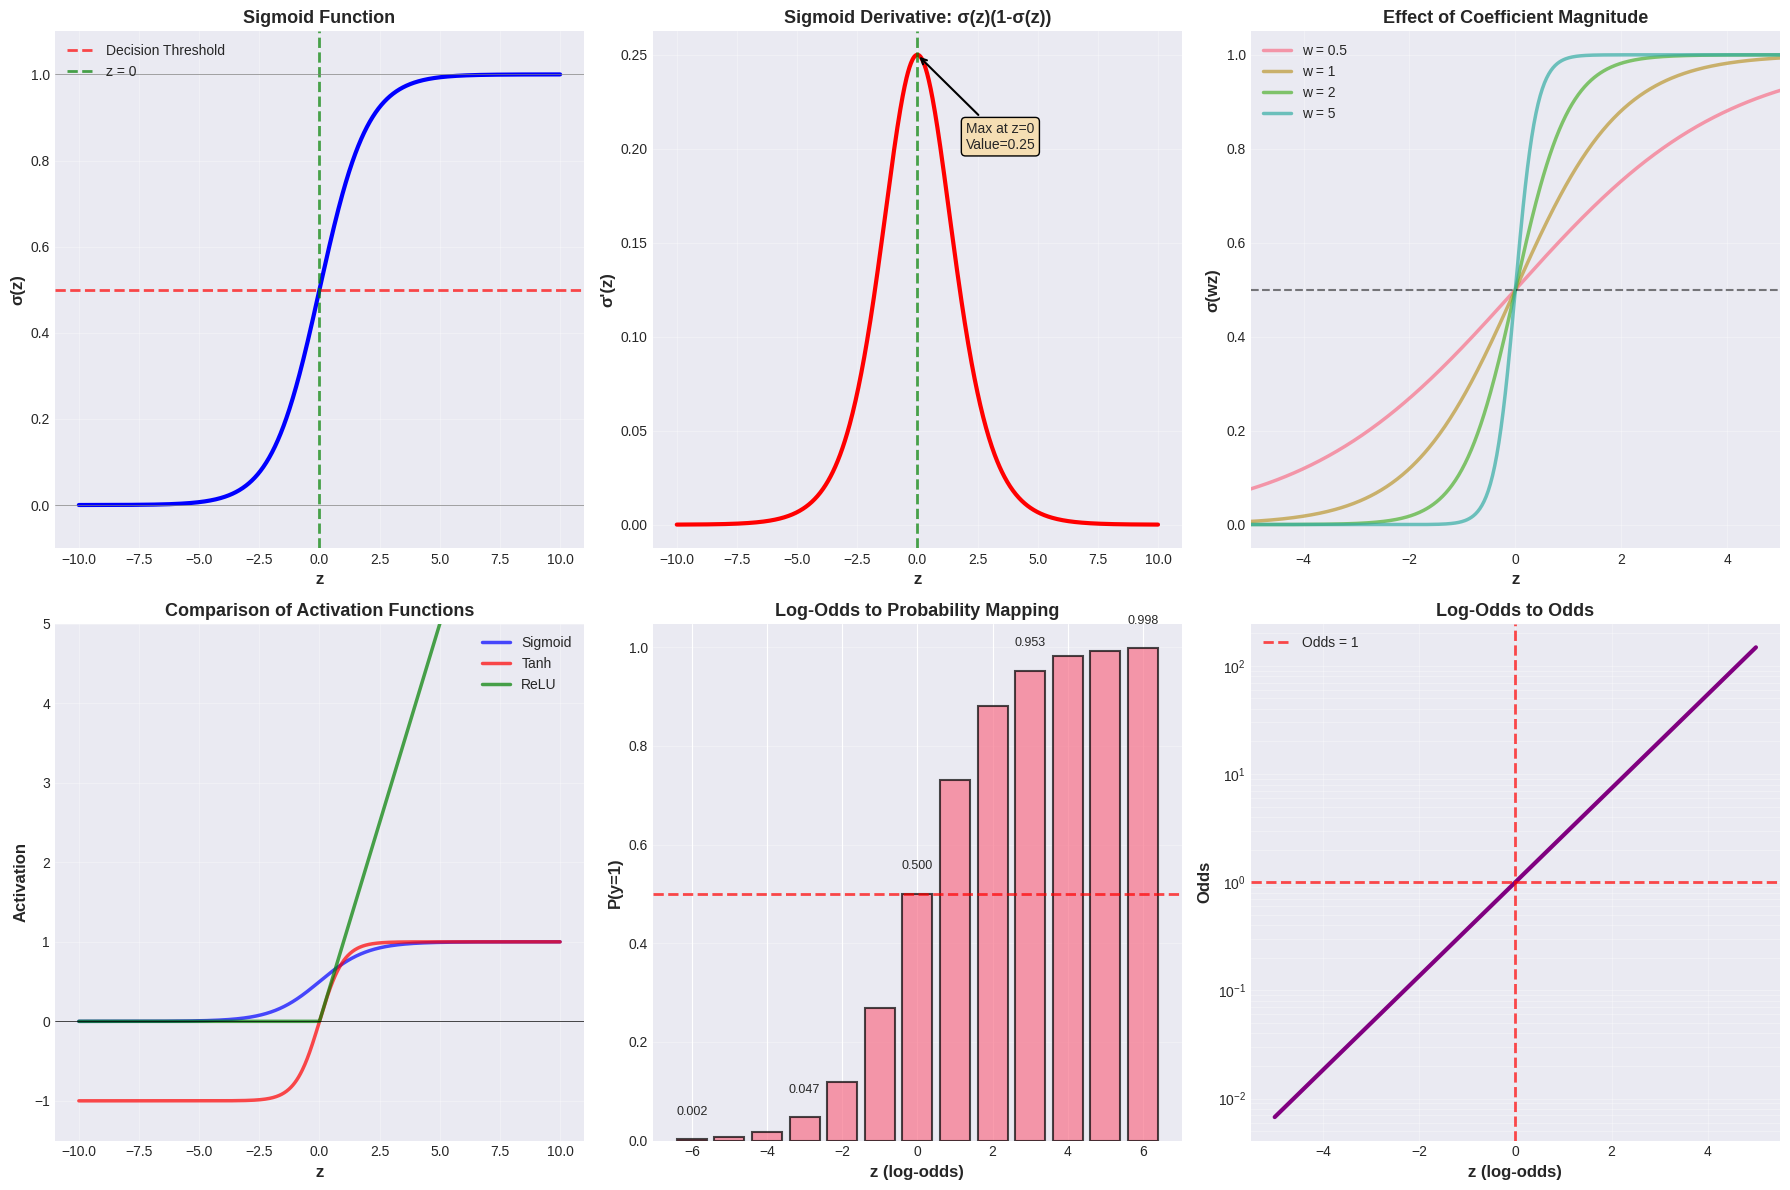

Sigmoid Function Key Values:
σ(-∞) ≈ 0.0000000000
σ(-5)  = 0.006693
σ(-2)  = 0.119203
σ(0)   = 0.500000
σ(2)   = 0.880797
σ(5)   = 0.993307
σ(∞)  ≈ 1.0000000000

Interpretation:
  z < -2: Probability < 12% (strong evidence for class 0)
  z ≈ 0:  Probability ≈ 50% (uncertain)
  z > 2:  Probability > 88% (strong evidence for class 1)


In [3]:
# Visualize sigmoid function and its properties

def sigmoid(z):
    """Sigmoid function"""
    return 1 / (1 + np.exp(-z))

def sigmoid_derivative(z):
    """Derivative of sigmoid"""
    s = sigmoid(z)
    return s * (1 - s)

# Create figure with multiple subplots
fig = plt.figure(figsize=(18, 12))

# Plot 1: Sigmoid function
ax1 = plt.subplot(2, 3, 1)
z = np.linspace(-10, 10, 1000)
ax1.plot(z, sigmoid(z), 'b-', linewidth=3)
ax1.axhline(y=0.5, color='r', linestyle='--', linewidth=2, alpha=0.7, label='Decision Threshold')
ax1.axvline(x=0, color='g', linestyle='--', linewidth=2, alpha=0.7, label='z = 0')
ax1.axhline(y=0, color='gray', linestyle='-', linewidth=0.5)
ax1.axhline(y=1, color='gray', linestyle='-', linewidth=0.5)
ax1.set_xlabel('z', fontsize=12, fontweight='bold')
ax1.set_ylabel('σ(z)', fontsize=12, fontweight='bold')
ax1.set_title('Sigmoid Function', fontsize=13, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)
ax1.set_ylim([-0.1, 1.1])

# Plot 2: Sigmoid derivative
ax2 = plt.subplot(2, 3, 2)
ax2.plot(z, sigmoid_derivative(z), 'r-', linewidth=3)
ax2.axvline(x=0, color='g', linestyle='--', linewidth=2, alpha=0.7)
ax2.set_xlabel('z', fontsize=12, fontweight='bold')
ax2.set_ylabel("σ'(z)", fontsize=12, fontweight='bold')
ax2.set_title('Sigmoid Derivative: σ(z)(1-σ(z))', fontsize=13, fontweight='bold')
ax2.grid(True, alpha=0.3)

# Add annotation for max derivative
ax2.annotate('Max at z=0\nValue=0.25', xy=(0, 0.25), xytext=(2, 0.2),
            fontsize=10, bbox=dict(boxstyle='round', facecolor='wheat'),
            arrowprops=dict(arrowstyle='->', lw=1.5))

# Plot 3: Effect of coefficient scaling
ax3 = plt.subplot(2, 3, 3)
for coef in [0.5, 1, 2, 5]:
    ax3.plot(z, sigmoid(coef * z), linewidth=2.5, label=f'w = {coef}', alpha=0.7)
ax3.axhline(y=0.5, color='k', linestyle='--', linewidth=1.5, alpha=0.5)
ax3.set_xlabel('z', fontsize=12, fontweight='bold')
ax3.set_ylabel('σ(wz)', fontsize=12, fontweight='bold')
ax3.set_title('Effect of Coefficient Magnitude', fontsize=13, fontweight='bold')
ax3.legend(fontsize=10)
ax3.grid(True, alpha=0.3)
ax3.set_xlim([-5, 5])

# Plot 4: Sigmoid vs other activation functions
ax4 = plt.subplot(2, 3, 4)
ax4.plot(z, sigmoid(z), 'b-', linewidth=2.5, label='Sigmoid', alpha=0.7)
ax4.plot(z, np.tanh(z), 'r-', linewidth=2.5, label='Tanh', alpha=0.7)
ax4.plot(z, np.maximum(0, z), 'g-', linewidth=2.5, label='ReLU', alpha=0.7)
ax4.axhline(y=0, color='k', linestyle='-', linewidth=0.5)
ax4.set_xlabel('z', fontsize=12, fontweight='bold')
ax4.set_ylabel('Activation', fontsize=12, fontweight='bold')
ax4.set_title('Comparison of Activation Functions', fontsize=13, fontweight='bold')
ax4.legend(fontsize=10)
ax4.grid(True, alpha=0.3)
ax4.set_ylim([-1.5, 5])

# Plot 5: Probability interpretation
ax5 = plt.subplot(2, 3, 5)
z_prob = np.linspace(-6, 6, 13)
prob = sigmoid(z_prob)
ax5.bar(z_prob, prob, width=0.8, alpha=0.7, edgecolor='black', linewidth=1.5)
ax5.axhline(y=0.5, color='r', linestyle='--', linewidth=2, alpha=0.7)
ax5.set_xlabel('z (log-odds)', fontsize=12, fontweight='bold')
ax5.set_ylabel('P(y=1)', fontsize=12, fontweight='bold')
ax5.set_title('Log-Odds to Probability Mapping', fontsize=13, fontweight='bold')
ax5.grid(True, alpha=0.3, axis='y')

# Add probability labels
for z_val, p_val in zip(z_prob[::3], prob[::3]):
    ax5.text(z_val, p_val + 0.05, f'{p_val:.3f}', ha='center', fontsize=9)

# Plot 6: Odds ratio
ax6 = plt.subplot(2, 3, 6)
z_odds = np.linspace(-5, 5, 100)
odds = np.exp(z_odds)
ax6.plot(z_odds, odds, 'purple', linewidth=3)
ax6.axvline(x=0, color='r', linestyle='--', linewidth=2, alpha=0.7, label='Odds = 1')
ax6.axhline(y=1, color='r', linestyle='--', linewidth=2, alpha=0.7)
ax6.set_xlabel('z (log-odds)', fontsize=12, fontweight='bold')
ax6.set_ylabel('Odds', fontsize=12, fontweight='bold')
ax6.set_title('Log-Odds to Odds', fontsize=13, fontweight='bold')
ax6.set_yscale('log')
ax6.legend(fontsize=10)
ax6.grid(True, alpha=0.3, which='both')

plt.tight_layout()
plt.show()

# Print key values
print("Sigmoid Function Key Values:")
print("="*70)
print(f"σ(-∞) ≈ {sigmoid(-100):.10f}")
print(f"σ(-5)  = {sigmoid(-5):.6f}")
print(f"σ(-2)  = {sigmoid(-2):.6f}")
print(f"σ(0)   = {sigmoid(0):.6f}")
print(f"σ(2)   = {sigmoid(2):.6f}")
print(f"σ(5)   = {sigmoid(5):.6f}")
print(f"σ(∞)  ≈ {sigmoid(100):.10f}")

print("\nInterpretation:")
print("  z < -2: Probability < 12% (strong evidence for class 0)")
print("  z ≈ 0:  Probability ≈ 50% (uncertain)")
print("  z > 2:  Probability > 88% (strong evidence for class 1)")

## 4. Maximum Likelihood Estimation <a id='mle'></a>

Logistic regression parameters are learned using **Maximum Likelihood Estimation** (MLE).

### Probabilistic Model

We model the probability of the output given the input:
$$P(y | \mathbf{x}; \mathbf{w}) = h(\mathbf{x})^y \cdot (1 - h(\mathbf{x}))^{1-y}$$

where $h(\mathbf{x}) = \sigma(\mathbf{w}^T\mathbf{x})$.

This can be written more explicitly:
$$P(y | \mathbf{x}; \mathbf{w}) = \begin{cases}
h(\mathbf{x}) & \text{if } y = 1 \\
1 - h(\mathbf{x}) & \text{if } y = 0
\end{cases}$$

### Likelihood Function

Given training data $\{(\mathbf{x}_i, y_i)\}_{i=1}^n$, the likelihood is:
$$L(\mathbf{w}) = \prod_{i=1}^{n} P(y_i | \mathbf{x}_i; \mathbf{w})$$

### Log-Likelihood

Taking logarithm (monotonic transformation, easier to optimize):
$$\ell(\mathbf{w}) = \log L(\mathbf{w}) = \sum_{i=1}^{n} \left[y_i \log h(\mathbf{x}_i) + (1-y_i)\log(1-h(\mathbf{x}_i))\right]$$

### Maximum Likelihood

Find parameters that maximize log-likelihood:
$$\mathbf{w}^* = \arg\max_{\mathbf{w}} \ell(\mathbf{w})$$

Equivalently, minimize negative log-likelihood:
$$\mathbf{w}^* = \arg\min_{\mathbf{w}} -\ell(\mathbf{w})$$

### Connection to Cross-Entropy Loss

The negative log-likelihood divided by $n$ gives the **cross-entropy loss**:
$$J(\mathbf{w}) = -\frac{1}{n}\ell(\mathbf{w}) = -\frac{1}{n}\sum_{i=1}^{n} \left[y_i \log h(\mathbf{x}_i) + (1-y_i)\log(1-h(\mathbf{x}_i))\right]$$

This is also called **log loss** or **binary cross-entropy**.

### Why Not MSE?

Mean squared error (MSE) is problematic for logistic regression:
- Non-convex optimization landscape
- Slow convergence due to saturation of sigmoid
- Not derived from probabilistic principles

Log loss is convex and has nice theoretical properties.

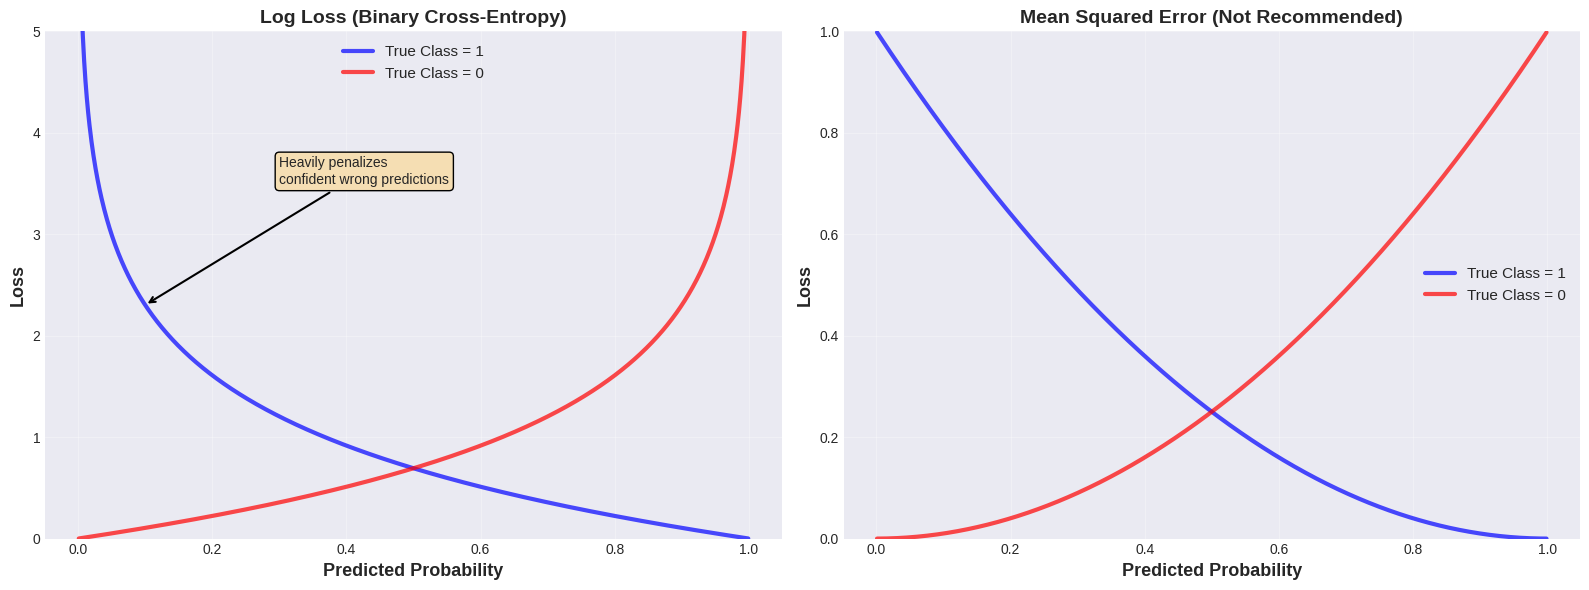

Loss Function Comparison:

Log Loss (Cross-Entropy):
  Advantages:
    - Strongly penalizes confident wrong predictions
    - Convex optimization landscape
    - Derived from probabilistic principles (MLE)
    - Gradient doesn't saturate when prediction is wrong

MSE for Classification:
  Problems:
    - Non-convex for logistic regression
    - Weaker penalty for confident wrong predictions
    - Gradient can saturate, slowing learning
    - No probabilistic interpretation

Example: True class = 1, Predicted = 0.1
  Log Loss: 2.3026
  MSE:      0.8100

Example: True class = 1, Predicted = 0.9
  Log Loss: 0.1054
  MSE:      0.0100


In [4]:
# Visualize log loss vs MSE for logistic regression

# Define loss functions
def log_loss_single(y_true, y_pred):
    """Binary cross-entropy for single example"""
    epsilon = 1e-15  # Avoid log(0)
    y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
    return -(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))

def mse_loss_single(y_true, y_pred):
    """Mean squared error for single example"""
    return (y_true - y_pred)**2

# Create prediction range
y_pred_range = np.linspace(0.001, 0.999, 1000)

# Calculate losses for both classes
log_loss_class1 = log_loss_single(1, y_pred_range)
log_loss_class0 = log_loss_single(0, y_pred_range)
mse_loss_class1 = mse_loss_single(1, y_pred_range)
mse_loss_class0 = mse_loss_single(0, y_pred_range)

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Log loss
ax = axes[0]
ax.plot(y_pred_range, log_loss_class1, 'b-', linewidth=3, 
       label='True Class = 1', alpha=0.7)
ax.plot(y_pred_range, log_loss_class0, 'r-', linewidth=3,
       label='True Class = 0', alpha=0.7)
ax.set_xlabel('Predicted Probability', fontsize=13, fontweight='bold')
ax.set_ylabel('Loss', fontsize=13, fontweight='bold')
ax.set_title('Log Loss (Binary Cross-Entropy)', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
ax.set_ylim([0, 5])

# Add annotations
ax.annotate('Heavily penalizes\nconfident wrong predictions',
           xy=(0.1, log_loss_single(1, 0.1)), xytext=(0.3, 3.5),
           fontsize=10, bbox=dict(boxstyle='round', facecolor='wheat'),
           arrowprops=dict(arrowstyle='->', lw=1.5))

# MSE loss
ax = axes[1]
ax.plot(y_pred_range, mse_loss_class1, 'b-', linewidth=3,
       label='True Class = 1', alpha=0.7)
ax.plot(y_pred_range, mse_loss_class0, 'r-', linewidth=3,
       label='True Class = 0', alpha=0.7)
ax.set_xlabel('Predicted Probability', fontsize=13, fontweight='bold')
ax.set_ylabel('Loss', fontsize=13, fontweight='bold')
ax.set_title('Mean Squared Error (Not Recommended)', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
ax.set_ylim([0, 1])

plt.tight_layout()
plt.show()

print("Loss Function Comparison:")
print("="*70)
print("\nLog Loss (Cross-Entropy):")
print("  Advantages:")
print("    - Strongly penalizes confident wrong predictions")
print("    - Convex optimization landscape")
print("    - Derived from probabilistic principles (MLE)")
print("    - Gradient doesn't saturate when prediction is wrong")
print("\nMSE for Classification:")
print("  Problems:")
print("    - Non-convex for logistic regression")
print("    - Weaker penalty for confident wrong predictions")
print("    - Gradient can saturate, slowing learning")
print("    - No probabilistic interpretation")

# Demonstrate gradient behavior
print("\nExample: True class = 1, Predicted = 0.1")
print(f"  Log Loss: {log_loss_single(1, 0.1):.4f}")
print(f"  MSE:      {mse_loss_single(1, 0.1):.4f}")
print("\nExample: True class = 1, Predicted = 0.9")
print(f"  Log Loss: {log_loss_single(1, 0.9):.4f}")
print(f"  MSE:      {mse_loss_single(1, 0.9):.4f}")

## 5. Cost Function and Optimization <a id='cost-function'></a>

### Cost Function

The cost function for logistic regression is the average log loss:
$$J(\mathbf{w}) = -\frac{1}{n}\sum_{i=1}^{n} \left[y_i \log(h(\mathbf{x}_i)) + (1-y_i)\log(1-h(\mathbf{x}_i))\right]$$

where $h(\mathbf{x}_i) = \sigma(\mathbf{w}^T\mathbf{x}_i)$.

### Gradient

The gradient of the cost function is:
$$\frac{\partial J}{\partial \mathbf{w}} = \frac{1}{n}\sum_{i=1}^{n} (h(\mathbf{x}_i) - y_i)\mathbf{x}_i = \frac{1}{n}\mathbf{X}^T(\mathbf{h} - \mathbf{y})$$

where $\mathbf{h}$ is the vector of predictions.

**Remarkably similar to linear regression gradient!** The sigmoid function's derivative cancels out nicely.

### Optimization Algorithms

**Gradient Descent**:
$$\mathbf{w}^{(t+1)} = \mathbf{w}^{(t)} - \alpha \nabla J(\mathbf{w}^{(t)})$$

**Newton's Method**:
$$\mathbf{w}^{(t+1)} = \mathbf{w}^{(t)} - \mathbf{H}^{-1} \nabla J(\mathbf{w}^{(t)})$$

where $\mathbf{H}$ is the Hessian matrix.

**L-BFGS** (Limited-memory BFGS):
- Quasi-Newton method
- Approximates Hessian using limited memory
- Very efficient for logistic regression
- Default in many implementations

**Stochastic Gradient Descent (SGD)**:
- Update using one sample at a time
- Or mini-batches
- Useful for very large datasets

### Regularized Cost Function

Adding L2 regularization:
$$J(\mathbf{w}) = -\frac{1}{n}\sum_{i=1}^{n} \left[y_i \log(h(\mathbf{x}_i)) + (1-y_i)\log(1-h(\mathbf{x}_i))\right] + \frac{\lambda}{2n}\|\mathbf{w}\|_2^2$$

Adding L1 regularization:
$$J(\mathbf{w}) = -\frac{1}{n}\sum_{i=1}^{n} \left[y_i \log(h(\mathbf{x}_i)) + (1-y_i)\log(1-h(\mathbf{x}_i))\right] + \frac{\lambda}{n}\|\mathbf{w}\|_1$$

### Convergence

The cost function is convex, so:
- Gradient descent converges to global minimum
- No local minima to worry about
- Different initialization leads to same solution

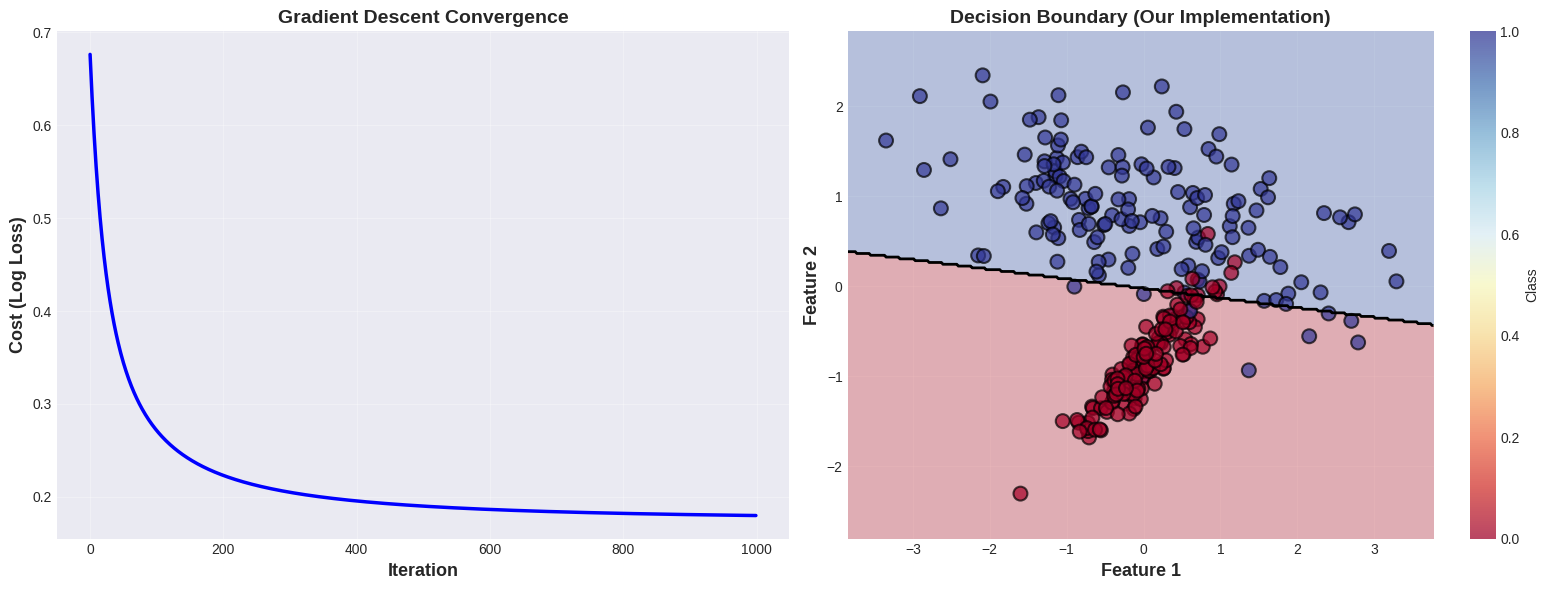

Model Comparison:

Our Implementation:
  Weights: [0.44798177 4.19209925]
  Bias: 0.105043
  Final Cost: 0.179947
  Accuracy: 0.9267

Scikit-learn:
  Weights: [0.41373162 3.92467346]
  Bias: 0.099690
  Accuracy: 0.9267

Note: Small differences due to different optimization algorithms
      Our implementation uses gradient descent
      Scikit-learn uses L-BFGS by default


In [5]:
# Implement logistic regression from scratch with gradient descent

class LogisticRegressionScratch:
    def __init__(self, learning_rate=0.01, n_iterations=1000, verbose=False):
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        self.verbose = verbose
        self.weights = None
        self.bias = None
        self.cost_history = []
        
    def _sigmoid(self, z):
        return 1 / (1 + np.exp(-z))
    
    def _compute_cost(self, X, y):
        m = len(y)
        h = self._sigmoid(X @ self.weights + self.bias)
        epsilon = 1e-15
        h = np.clip(h, epsilon, 1 - epsilon)
        cost = -(1/m) * np.sum(y * np.log(h) + (1 - y) * np.log(1 - h))
        return cost
    
    def fit(self, X, y):
        n_samples, n_features = X.shape
        
        # Initialize parameters
        self.weights = np.zeros(n_features)
        self.bias = 0
        
        # Gradient descent
        for i in range(self.n_iterations):
            # Forward pass
            linear_pred = X @ self.weights + self.bias
            predictions = self._sigmoid(linear_pred)
            
            # Compute gradients
            dw = (1/n_samples) * X.T @ (predictions - y)
            db = (1/n_samples) * np.sum(predictions - y)
            
            # Update parameters
            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db
            
            # Record cost
            cost = self._compute_cost(X, y)
            self.cost_history.append(cost)
            
            if self.verbose and i % 100 == 0:
                print(f"Iteration {i}, Cost: {cost:.6f}")
    
    def predict_proba(self, X):
        linear_pred = X @ self.weights + self.bias
        return self._sigmoid(linear_pred)
    
    def predict(self, X, threshold=0.5):
        return (self.predict_proba(X) >= threshold).astype(int)

# Generate synthetic data
np.random.seed(42)
X_train_scratch, y_train_scratch = make_classification(
    n_samples=300, n_features=2, n_informative=2,
    n_redundant=0, n_clusters_per_class=1,
    random_state=42
)

# Standardize features
scaler = StandardScaler()
X_train_scratch = scaler.fit_transform(X_train_scratch)

# Train our implementation
model_scratch = LogisticRegressionScratch(learning_rate=0.1, n_iterations=1000)
model_scratch.fit(X_train_scratch, y_train_scratch)

# Train sklearn for comparison
model_sklearn = LogisticRegression()
model_sklearn.fit(X_train_scratch, y_train_scratch)

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Cost function convergence
ax = axes[0]
ax.plot(model_scratch.cost_history, 'b-', linewidth=2.5)
ax.set_xlabel('Iteration', fontsize=13, fontweight='bold')
ax.set_ylabel('Cost (Log Loss)', fontsize=13, fontweight='bold')
ax.set_title('Gradient Descent Convergence', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)

# Plot 2: Decision boundary comparison
ax = axes[1]

# Create mesh
h = 0.02
x_min, x_max = X_train_scratch[:, 0].min() - 0.5, X_train_scratch[:, 0].max() + 0.5
y_min, y_max = X_train_scratch[:, 1].min() - 0.5, X_train_scratch[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Predict on mesh
Z_scratch = model_scratch.predict(np.c_[xx.ravel(), yy.ravel()])
Z_scratch = Z_scratch.reshape(xx.shape)

# Plot decision boundary
ax.contourf(xx, yy, Z_scratch, alpha=0.3, cmap='RdYlBu')
ax.contour(xx, yy, Z_scratch, colors='black', linewidths=2, levels=[0.5])

# Plot data points
scatter = ax.scatter(X_train_scratch[:, 0], X_train_scratch[:, 1],
                    c=y_train_scratch, cmap='RdYlBu', edgecolors='black',
                    linewidths=1.5, s=100, alpha=0.7)

ax.set_xlabel('Feature 1', fontsize=13, fontweight='bold')
ax.set_ylabel('Feature 2', fontsize=13, fontweight='bold')
ax.set_title('Decision Boundary (Our Implementation)', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
plt.colorbar(scatter, ax=ax, label='Class')

plt.tight_layout()
plt.show()

# Compare results
print("Model Comparison:")
print("="*70)
print("\nOur Implementation:")
print(f"  Weights: {model_scratch.weights}")
print(f"  Bias: {model_scratch.bias:.6f}")
print(f"  Final Cost: {model_scratch.cost_history[-1]:.6f}")
print(f"  Accuracy: {accuracy_score(y_train_scratch, model_scratch.predict(X_train_scratch)):.4f}")

print("\nScikit-learn:")
print(f"  Weights: {model_sklearn.coef_[0]}")
print(f"  Bias: {model_sklearn.intercept_[0]:.6f}")
print(f"  Accuracy: {model_sklearn.score(X_train_scratch, y_train_scratch):.4f}")

print("\nNote: Small differences due to different optimization algorithms")
print("      Our implementation uses gradient descent")
print("      Scikit-learn uses L-BFGS by default")

## 6. Decision Boundaries <a id='decision-boundaries'></a>

### Linear Decision Boundary

The decision boundary is where $P(y=1|\mathbf{x}) = 0.5$:
$$\sigma(\mathbf{w}^T\mathbf{x} + b) = 0.5$$

Since $\sigma(0) = 0.5$, this occurs when:
$$\mathbf{w}^T\mathbf{x} + b = 0$$

This is a **hyperplane** in feature space:
- In 2D: a line
- In 3D: a plane
- In higher dimensions: a hyperplane

### Non-linear Decision Boundaries

Logistic regression with polynomial features can create non-linear boundaries:
- Add features like $x_1^2, x_2^2, x_1 x_2$, etc.
- Decision boundary is still linear in **transformed** feature space
- Appears non-linear in original feature space

For example, with features $[1, x_1, x_2, x_1^2, x_2^2, x_1 x_2]$:
$$w_0 + w_1 x_1 + w_2 x_2 + w_3 x_1^2 + w_4 x_2^2 + w_5 x_1 x_2 = 0$$

This can represent circles, ellipses, or other curved boundaries.

### Distance from Decision Boundary

The magnitude of $\mathbf{w}^T\mathbf{x} + b$ indicates:
- Distance from decision boundary
- Confidence in prediction

**Large positive**: Strong evidence for class 1
**Near zero**: Close to decision boundary, uncertain
**Large negative**: Strong evidence for class 0

### Multiple Decision Boundaries

We can use multiple logistic regression models for complex problems:
- One-vs-rest (OvR): One classifier per class
- One-vs-one (OvO): One classifier per pair of classes
- Discussed more in multiclass section

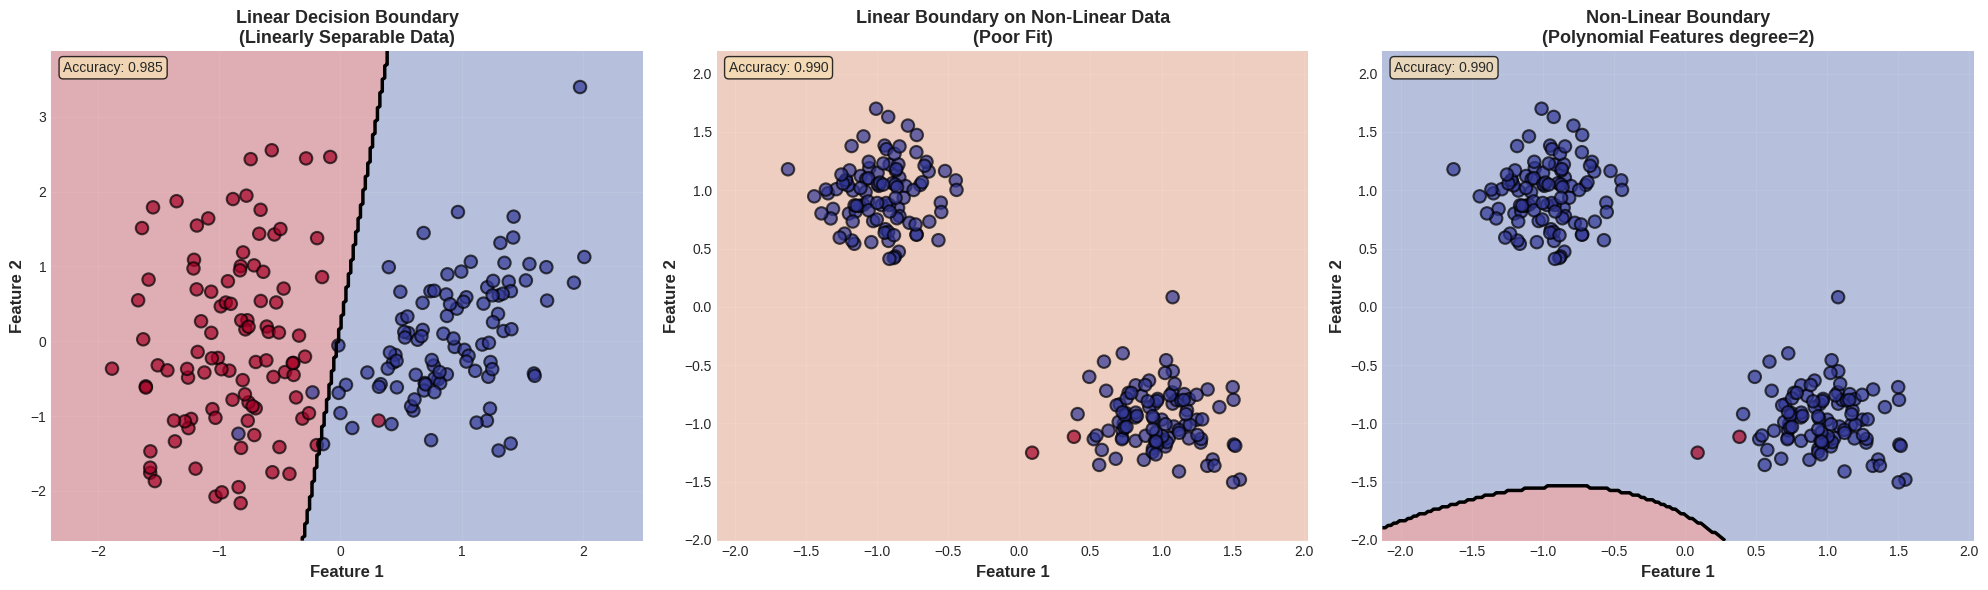

Decision Boundary Analysis:

1. Linear Boundary on Linearly Separable Data:
   - Perfect fit possible
   - Single straight line separates classes

2. Linear Boundary on Non-Linear Data:
   - Poor performance (low accuracy)
   - Cannot capture circular pattern
   - Model is underfitting

3. Non-Linear Boundary (Polynomial Features):
   - Much better fit
   - Captures circular decision boundary
   - Still logistic regression, just with transformed features


In [6]:
# Visualize linear and non-linear decision boundaries

# Generate datasets with different separability
np.random.seed(42)

# Linearly separable
X_linear, y_linear = make_classification(
    n_samples=200, n_features=2, n_informative=2,
    n_redundant=0, n_clusters_per_class=1,
    class_sep=2.0, random_state=42
)

# Non-linearly separable (circular)
X_circle, y_circle = make_blobs(
    n_samples=200, centers=2, n_features=2,
    cluster_std=1.0, random_state=42
)
# Make it circular
radius = np.sqrt(X_circle[:, 0]**2 + X_circle[:, 1]**2)
y_circle = (radius > 3).astype(int)

# Standardize
scaler_linear = StandardScaler()
X_linear = scaler_linear.fit_transform(X_linear)

scaler_circle = StandardScaler()
X_circle = scaler_circle.fit_transform(X_circle)

# Train models
model_linear = LogisticRegression()
model_linear.fit(X_linear, y_linear)

# For circular data, use polynomial features
poly = PolynomialFeatures(degree=2, include_bias=False)
X_circle_poly = poly.fit_transform(X_circle)

model_circle_linear = LogisticRegression()
model_circle_linear.fit(X_circle, y_circle)

model_circle_poly = LogisticRegression()
model_circle_poly.fit(X_circle_poly, y_circle)

# Plotting function
def plot_decision_boundary(X, y, model, title, ax, poly_features=None):
    h = 0.02
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    
    mesh_data = np.c_[xx.ravel(), yy.ravel()]
    if poly_features is not None:
        mesh_data = poly_features.transform(mesh_data)
    
    Z = model.predict(mesh_data)
    Z = Z.reshape(xx.shape)
    
    # Plot decision boundary and regions
    ax.contourf(xx, yy, Z, alpha=0.3, cmap='RdYlBu')
    ax.contour(xx, yy, Z, colors='black', linewidths=2.5, levels=[0.5])
    
    # Plot data points
    scatter = ax.scatter(X[:, 0], X[:, 1], c=y, cmap='RdYlBu',
                        edgecolors='black', linewidths=1.5, s=80, alpha=0.7)
    
    ax.set_xlabel('Feature 1', fontsize=12, fontweight='bold')
    ax.set_ylabel('Feature 2', fontsize=12, fontweight='bold')
    ax.set_title(title, fontsize=13, fontweight='bold')
    ax.grid(True, alpha=0.3)
    
    # Add accuracy
    if poly_features is not None:
        X_eval = poly_features.transform(X)
    else:
        X_eval = X
    accuracy = accuracy_score(y, model.predict(X_eval))
    ax.text(0.02, 0.98, f'Accuracy: {accuracy:.3f}',
           transform=ax.transAxes, fontsize=10,
           verticalalignment='top',
           bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

# Create plots
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Linear separable
plot_decision_boundary(X_linear, y_linear, model_linear,
                      'Linear Decision Boundary\n(Linearly Separable Data)',
                      axes[0])

# Non-linear without polynomial features
plot_decision_boundary(X_circle, y_circle, model_circle_linear,
                      'Linear Boundary on Non-Linear Data\n(Poor Fit)',
                      axes[1])

# Non-linear with polynomial features
plot_decision_boundary(X_circle, y_circle, model_circle_poly,
                      'Non-Linear Boundary\n(Polynomial Features degree=2)',
                      axes[2], poly_features=poly)

plt.tight_layout()
plt.show()

print("Decision Boundary Analysis:")
print("="*70)
print("\n1. Linear Boundary on Linearly Separable Data:")
print("   - Perfect fit possible")
print("   - Single straight line separates classes")
print("\n2. Linear Boundary on Non-Linear Data:")
print("   - Poor performance (low accuracy)")
print("   - Cannot capture circular pattern")
print("   - Model is underfitting")
print("\n3. Non-Linear Boundary (Polynomial Features):")
print("   - Much better fit")
print("   - Captures circular decision boundary")
print("   - Still logistic regression, just with transformed features")

## 7. Summary and Best Practices

### Key Concepts Recap

**Logistic Regression**: Classification algorithm that models probability using sigmoid function

**Sigmoid Function**: Maps any real value to [0,1], interpreted as probability

**Log Loss**: Appropriate cost function, derived from maximum likelihood estimation

**Decision Boundary**: Hyperplane where $P(y=1|\mathbf{x}) = 0.5$

**Convex Optimization**: Guaranteed to find global minimum

### When to Use Logistic Regression

**Good fit when**:
- Binary or multiclass classification
- Features have approximately linear relationship with log-odds
- You need probabilistic predictions
- Interpretability is important
- You want a simple, fast baseline model

**May not be best when**:
- Highly non-linear decision boundaries (consider polynomial features or other models)
- Complex feature interactions (consider tree-based methods)
- Very high-dimensional sparse data (though can work with regularization)

### Best Practices

**1. Feature Scaling**
- Always standardize features
- Especially important with regularization

**2. Handle Class Imbalance**
- Use class weights
- Adjust decision threshold
- Use appropriate metrics (F1, AUC-ROC)

**3. Regularization**
- Usually beneficial, prevents overfitting
- L2 for multicollinearity
- L1 for feature selection

**4. Feature Engineering**
- Create polynomial features for non-linear relationships
- Feature interactions can be important
- Domain knowledge helps

**5. Model Evaluation**
- Don't rely only on accuracy
- Use confusion matrix, precision, recall, F1
- Plot ROC curve and check AUC
- Use cross-validation

**6. Threshold Selection**
- Default 0.5 may not be optimal
- Adjust based on cost of false positives vs false negatives
- Use precision-recall curve to guide selection

### Common Mistakes to Avoid

**Not standardizing features**: Leads to poor convergence and makes regularization ineffective

**Using MSE as loss**: Wrong loss function for classification

**Ignoring class imbalance**: Can lead to poor performance on minority class

**Not checking assumptions**: Logistic regression assumes linear relationship with log-odds

**Overfitting with too many features**: Use regularization or feature selection

**Using only accuracy**: Can be misleading, especially with imbalanced data

### Final Thoughts

Logistic regression is:
- Simple yet powerful
- Interpretable and fast
- Great baseline model
- Foundation for understanding more complex models

Master logistic regression and you'll have a solid foundation for machine learning.